Below is an integrated pipeline that ties together the various tools we discussed:      

Pair Selection:     
– Use correlation and cointegration to narrow down candidate pairs.      
– Optionally, use PCA and clustering to further group similar assets.      

Dynamic Signal Generation:      
– Once a pair is selected, use a Kalman Filter to dynamically estimate the hedge ratio (and thus the spread) between the two assets.      
– Compute a rolling z‑score (or use the filter’s estimates) to generate entry/exit signals.      

Backtesting:      
– Use vectorbt (or any backtesting framework) to simulate the paired trades based on the adaptive signals.     

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pykalman import KalmanFilter
import vectorbt as vbt

# -------------------------------
# Step 1: Data Loading using MT5 API
# -------------------------------
if not mt5.initialize():
    print("MT5 Initialization Failed")
    mt5.shutdown()
    quit()

# Retrieve all symbols from MT5
symbols = [s.name for s in mt5.symbols_get()]
print(f"✅ Found {len(symbols)} symbols in MT5")

# Limit to top 50 symbols for performance
symbols = symbols[:50]

# Function to fetch historical data from MT5
def get_mt5_data(symbol, n_bars=1000, timeframe=mt5.TIMEFRAME_D1):
    rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, n_bars)
    if rates is None:
        print(f"⚠️ Could not retrieve data for {symbol}")
        return None
    df = pd.DataFrame(rates)
    df["time"] = pd.to_datetime(df["time"], unit="s")
    df.set_index("time", inplace=True)
    return df[["close"]]

# Load data for all symbols
data = {symbol: get_mt5_data(symbol) for symbol in symbols if get_mt5_data(symbol) is not None}

# Merge data into one DataFrame with a multi-index (symbol, feature)
df = pd.concat(data.values(), axis=1, keys=data.keys()).dropna()
print(f"📊 Data Loaded for {len(df.columns)//2} Symbols")


✅ Found 2061 symbols in MT5
📊 Data Loaded for 25 Symbols


In [2]:

# -------------------------------
# Step 2: Prepare Price Data for Pair Selection
# -------------------------------
# Extract just the "close" prices to get a DataFrame with single-level columns
df_prices = df.xs('close', axis=1, level=1)
returns = df_prices.pct_change().dropna()

# Compute the correlation matrix (columns are symbols now)
corr_matrix = returns.corr()
print("Correlation Matrix:")
print(corr_matrix)


Correlation Matrix:
          EURUSD    GBPUSD    USDCHF    USDJPY    USDCAD    AUDUSD    AUDNZD  \
EURUSD  1.000000  0.780128 -0.736896 -0.434969 -0.586613  0.674502  0.020042   
GBPUSD  0.780128  1.000000 -0.619409 -0.420554 -0.630336  0.719728  0.021344   
USDCHF -0.736896 -0.619409  1.000000  0.540276  0.493095 -0.589198  0.024836   
USDJPY -0.434969 -0.420554  0.540276  1.000000  0.252563 -0.407078  0.092968   
USDCAD -0.586613 -0.630336  0.493095  0.252563  1.000000 -0.775543 -0.175122   
AUDUSD  0.674502  0.719728 -0.589198 -0.407078 -0.775543  1.000000  0.254445   
AUDNZD  0.020042  0.021344  0.024836  0.092968 -0.175122  0.254445  1.000000   
AUDCAD  0.466675  0.494919 -0.427767 -0.381727 -0.218942  0.785352  0.220496   
AUDCHF  0.150693  0.312526  0.190804 -0.003642 -0.495450  0.680458  0.332438   
AUDJPY  0.247187  0.302866 -0.073294  0.508348 -0.505924  0.579337  0.322672   
CHFJPY  0.164979  0.075318 -0.279135  0.656318 -0.154203  0.064901  0.088684   
EURGBP  0.129716 -0.

In [3]:

# -------------------------------
# Step 3: Candidate Pair Selection using Correlation & Cointegration
# -------------------------------
candidate_pairs = []
symbol_list = df_prices.columns.tolist()

for i, sym1 in enumerate(symbol_list):
    for sym2 in symbol_list[i+1:]:
        corr_value = corr_matrix.loc[sym1, sym2]
        if corr_value > 0.8:
            # Run cointegration test on the two price series
            score, pvalue, _ = coint(df_prices[sym1], df_prices[sym2])
            if pvalue < 0.05:
                candidate_pairs.append((sym1, sym2, pvalue, corr_value))
                
print("Candidate Pairs (High Correlation & Cointegrated):")
for pair in candidate_pairs:
    print(pair)

if len(candidate_pairs) == 0:
    raise ValueError("No candidate pairs found with high correlation and cointegration.")

# Optionally, you can also use PCA & Clustering here to further group symbols,
# but for this example, we'll proceed with candidate pairs.


Candidate Pairs (High Correlation & Cointegrated):
('AUDUSD', 'NZDUSD', np.float64(0.029071952477892585), np.float64(0.891053344243205))
('AUDJPY', 'CADJPY', np.float64(0.020139018449132847), np.float64(0.8043796863766559))
('CHFJPY', 'EURJPY', np.float64(0.025397607487565806), np.float64(0.8154419546327693))


In [4]:
# Optional: PCA & Clustering for additional insight
pca = PCA(n_components=2)
pca_components = pca.fit_transform(returns.T)
pca_df = pd.DataFrame(pca_components, index=returns.columns, columns=['PC1','PC2'])
print("PCA Components:")
print(pca_df)

kmeans = KMeans(n_clusters=2, random_state=42)
pca_df['cluster'] = kmeans.fit_predict(pca_df)
print("Cluster Assignment:")
print(pca_df[['cluster']])


PCA Components:
             PC1       PC2
EURUSD -0.068192 -0.020048
GBPUSD -0.089713 -0.018949
USDCHF  0.112433  0.022101
USDJPY  0.072538  0.088778
USDCAD  0.126676 -0.040845
AUDUSD -0.141829  0.039940
AUDNZD  0.023960  0.006956
AUDCAD -0.046538  0.005291
AUDCHF -0.060629  0.068135
AUDJPY -0.100707  0.134864
CHFJPY -0.008567  0.060643
EURGBP  0.053044 -0.007520
EURAUD  0.104557 -0.066161
EURJPY -0.026952  0.074751
EURCHF  0.012880  0.008218
EURNZD  0.097594 -0.052595
EURCAD  0.027150 -0.054857
GBPCHF -0.008660  0.009418
GBPJPY -0.048592  0.075931
CADCHF  0.016843  0.056910
CADJPY -0.022842  0.123524
GBPAUD  0.082859 -0.065064
GBPCAD  0.005416 -0.053869
GBPNZD  0.076163 -0.051713
NZDCAD -0.039870 -0.007613
NZDCHF -0.053501  0.055236
NZDJPY -0.093532  0.121715
NZDUSD -0.134830  0.027091
USDSGD  0.097528 -0.003666
AUDSGD -0.076452  0.042628
CHFSGD  0.016224 -0.031500
EURDKK  0.031571 -0.006063
EURHKD -0.066269 -0.019982
EURNOK  0.125667 -0.069447
EURPLN  0.072275 -0.019012
EURSEK  0.09

c:\Users\moham\miniconda3\envs\ml\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\moham\miniconda3\envs\ml\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\moham\miniconda3\envs\ml\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\moham\miniconda3\envs\ml\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\moham\miniconda3\envs\ml\Lib\subprocess.py", line 1538, in _execute_c

In [5]:

# -------------------------------
# Step 4: Select a Pair & Align the Data
# -------------------------------
# Choose the first candidate pair as an example
pair1, pair2, pval, corr_val = candidate_pairs[0]
print(f"Selected Pair: {pair1} vs {pair2} (p-value: {pval:.4f}, corr: {corr_val:.2f})")

# Align the two series
S1 = df_prices[pair1].dropna()
S2 = df_prices[pair2].dropna()
df_pair = pd.concat([S1, S2], axis=1).dropna()
df_pair.columns = [pair1, pair2]


Selected Pair: AUDUSD vs NZDUSD (p-value: 0.0291, corr: 0.89)


In [6]:

# -------------------------------
# Step 5: Dynamic Signal Generation with Kalman Filter
# -------------------------------
# Function to estimate dynamic hedge ratio using a Kalman Filter
def kalman_filter_estimate(y, x):
    n = len(y)
    beta = 0.0
    P = 1.0
    Q = 1e-5  # Process noise variance
    R = 1e-2  # Measurement noise variance
    beta_history = []
    
    for i in range(n):
        beta_pred = beta
        P_pred = P + Q
        
        # Kalman Gain computation
        K = P_pred * x[i] / (x[i]**2 * P_pred + R)
        
        # Update the state estimate using the measurement y[i]
        beta = beta_pred + K * (y[i] - beta_pred * x[i])
        P = (1 - K * x[i]) * P_pred
        
        beta_history.append(beta)
    return np.array(beta_history)

# Estimate dynamic hedge ratio for the pair: S1 = beta_t * S2 + error
beta_est = kalman_filter_estimate(df_pair[pair1].values, df_pair[pair2].values)
df_pair['beta'] = beta_est

# Compute dynamic spread: difference between S1 and the hedged S2
df_pair['spread'] = df_pair[pair1] - df_pair['beta'] * df_pair[pair2]

# Use a rolling window to compute spread mean and standard deviation (or you could use Kalman state covariances)
window = 60
df_pair['spread_mean'] = df_pair['spread'].rolling(window).mean()
df_pair['spread_std'] = df_pair['spread'].rolling(window).std()
df_pair['zscore'] = (df_pair['spread'] - df_pair['spread_mean']) / df_pair['spread_std']


In [7]:

# -------------------------------
# Step 6: Trading Signal Generation
# -------------------------------
# Define thresholds for signal generation
entry_threshold = 1.5  # for entering trades
exit_threshold = 0.5   # for exiting trades

df_pair['long_signal'] = df_pair['zscore'] < -entry_threshold
df_pair['short_signal'] = df_pair['zscore'] > entry_threshold
df_pair['exit_signal'] = abs(df_pair['zscore']) < exit_threshold


In [8]:

# -------------------------------
# Step 7: Backtesting with vectorbt
# -------------------------------
# Here we simulate trades on the first asset's price (S1) while assuming a hedged position against S2.
entries = df_pair['long_signal']
short_entries = df_pair['short_signal']
exits = df_pair['exit_signal']

portfolio = vbt.Portfolio.from_signals(
    close=df_pair[pair1],
    entries=entries,
    exits=exits,
    short_entries=short_entries,
    short_exits=exits,
    size=1,
    size_type='percent',
    init_cash=10000,
    fees=0.001,  # example fee rate
    freq='1D'
)

print(portfolio.stats())
portfolio.plot().show()


Start                                2021-04-29 00:00:00
End                                  2025-03-05 00:00:00
Period                                 996 days 00:00:00
Start Value                                      10000.0
End Value                                   10495.182943
Total Return [%]                                4.951829
Benchmark Return [%]                           -19.02309
Max Gross Exposure [%]                             100.0
Total Fees Paid                               577.999539
Max Drawdown [%]                                9.337445
Max Drawdown Duration                  521 days 00:00:00
Total Trades                                          28
Total Closed Trades                                   28
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   39.285714
Best Trade [%]                                  6.091998
Worst Trade [%]                

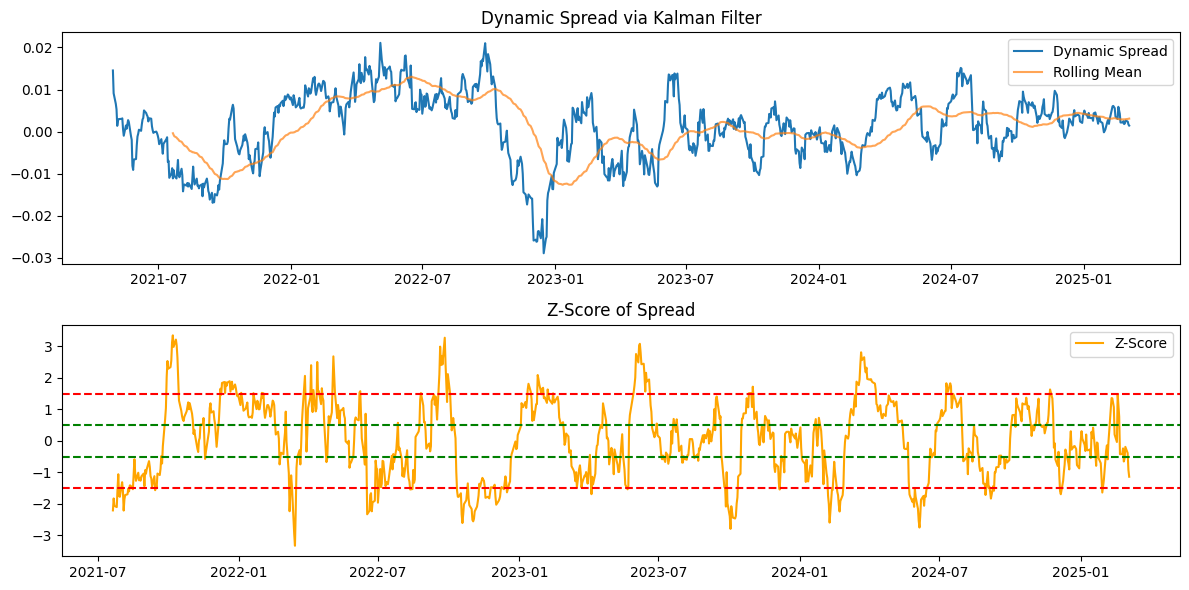

True

In [9]:

# -------------------------------
# Optional: Visualization of the Dynamic Spread and Z-Score
# -------------------------------
plt.figure(figsize=(12, 6))
plt.subplot(2,1,1)
plt.plot(df_pair.index, df_pair['spread'], label='Dynamic Spread')
plt.plot(df_pair.index, df_pair['spread_mean'], label='Rolling Mean', alpha=0.7)
plt.legend()
plt.title('Dynamic Spread via Kalman Filter')

plt.subplot(2,1,2)
plt.plot(df_pair.index, df_pair['zscore'], label='Z-Score', color='orange')
plt.axhline(entry_threshold, color='red', linestyle='--')
plt.axhline(-entry_threshold, color='red', linestyle='--')
plt.axhline(exit_threshold, color='green', linestyle='--')
plt.axhline(-exit_threshold, color='green', linestyle='--')
plt.legend()
plt.title('Z-Score of Spread')
plt.tight_layout()
plt.show()

# -------------------------------
# Shutdown MT5 connection
# -------------------------------
mt5.shutdown()
